# Python speed studies
This notebook uses the %timeit magic to measure and compare the performance of some large operations.

Credit: Nick Smith (Fermilab)

In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
%%timeit
# Use %%timeit to time a whole cell
x=1

3.57 ns ± 0.0138 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [6]:
# Use %timeit to time a single command
%timeit y=[1, 2]

18.9 ns ± 0.126 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


## Some simple array operations

In [9]:
%timeit np.empty(100_000)
%timeit np.zeros(100_000)
%timeit np.arange(100_000)

102 ns ± 0.541 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)
3.89 μs ± 268 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
22.8 μs ± 108 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
%%timeit
a = np.arange(100_000)
b = a*2

46.9 μs ± 281 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
%%timeit
c = list(range(100_000))
d = [i*2 for i in c]

2.15 ms ± 17.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Barnsley fern
The Barnsley fern is a fractal that you can generate with some simple matrix multiplications. See https://en.wikipedia.org/wiki/Barnsley_fern. 

Starting from an initial point, say $(x_0,\,y_0)=(0,\,0)$, the next point is generated by randomly applying one of four functions, $f_i(x, y)$:

$$
(x_{n+1}, y_{n+1}) = f_i(x_n, y_n)
$$

where each $f_i(x, y)$ consists of a matrix multiplication and addition:

$$
f_i(x, y) = \left[\begin{array}{cc} a & b \\ c & d \end{array} \right] \left[\begin{array}{c} x \\ y \end{array}\right] + \left[\begin{array}{c} e \\ f \end{array} \right].
$$

The coefficients and probabilities $p$ are:
| $w$ | $a$ | $b$ | $c$ | $d$ | $e$ | $f$ | $p$ | Portion generated | 
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| $f_1$ | $0$ | $0$ | $0$ | $0.16$ | $0$ | $0$ | $0.01$ | Stem |
| $f_2$ | $0.85$ | $0.04$ | $-0.04$ | $0.85$ | $0$ | $1.60$ | $0.85$ | Successively smaller leaflets |
| $f_3$ | $0.20$ | $-0.26$ | $0.23$ | $0.22$ | $0$ | $1.60$ | $0.07$ | Largest left-hand leaflet |
| $f_4$ | $-0.15$ | $0.28$ | $0.26$ | $0.24$ | $0$ | $0.44$ | $0.07$ | Largest right-hand leaflet |

The first cell below creates the arrays corresponding to the matrices (abcd) and offset (ef), plus an array for the probabilities. The next three cells run through 10,000 iterations using three different methods:

1. A simple for loop;
2. A vectorized for loop with 100 operations done in parallel;
3. A for loop compiled with numba.

Finally, we run 1,000,000 iterations and draw the fern.

In [27]:
matrices = np.array([
    [[0,	0],	[0,	0.16]],
    [[0.85,	0.04],	[-0.04,	0.85]],
    [[0.20,	-0.26],	[0.23,	0.22]],
    [[-0.15, 0.28],	[0.26,	0.24]],
])
offsets = np.array([
    [0, 0],
    [0, 1.6],
    [0, 1.6],
    [0, 0.44],
])
probabilities = np.array([0.01, 0.85, 0.07, 0.07])

In [28]:
%%timeit

# 1. Do the iteration in a for loop. Each iteration does a matrix multiplication to compute the next point in the series.
# David's result: 55.2 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

current = np.array([0, 0])
allpoints = np.empty(shape=(10_000, 2))

for i in range(10_000):
    index = np.random.choice(4, p=probabilities)
    current = matrices[index] @ current + offsets[index]
    allpoints[i] = current

x = allpoints[:, 0]
y = allpoints[:, 1]

55.2 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%%timeit
# 2. Similar to the previous cell, but doing 100 operations at a time (i.e. in parallel)
# David's result: 1.11 ms ± 18.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

nparallel = 100
ntotal = 10_000
nsteps = ntotal // nparallel
current = np.zeros((nparallel, 2))
allpoints = np.empty(shape=(nsteps, nparallel, 2))

for i in range(nsteps):
    index = np.random.choice(4, size=nparallel, p=probabilities)
    current = np.einsum("ijk,ik->ij", matrices[index], current) + offsets[index]
    allpoints[i] = current

x = allpoints.reshape((-1, 2))[:, 0]
y = allpoints.reshape((-1, 2))[:, 1]

1.11 ms ± 18.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [30]:
# 3. Use numba to do "just in time" compilation (JIT) of the matrix multiplication function
import numba

cumprob = np.zeros(5)
cumprob[1:] = np.cumsum(probabilities)

@numba.jit
def numba_choice(n, rng):
    return np.searchsorted(cumprob, rng.random(n)) - 1


@numba.jit
def build_fern(allpoints, rng):
    nsteps = len(allpoints)
    
    for i in range(1, nsteps):
        index = numba_choice(1, rng)[0]
        allpoints[i] = matrices[index] @ allpoints[i-1] + offsets[index]
    
    x = allpoints[:, 0]
    y = allpoints[:, 1]
    return x, y




In [35]:
%%timeit 
# David's result: 1.27 ms ± 23 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
allpoints = np.empty(shape=(10_000, 2))
rng = np.random.default_rng(42)
x, y = build_fern(allpoints, rng)


1.28 ms ± 11.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Drawing the fern


In [36]:
# Now do it for real
allpoints = np.zeros(shape=(100, 2))
rng = np.random.default_rng(42)
x, y = build_fern(allpoints, rng)
%timeit x, y = build_fern(allpoints, rng)

16.9 μs ± 77 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


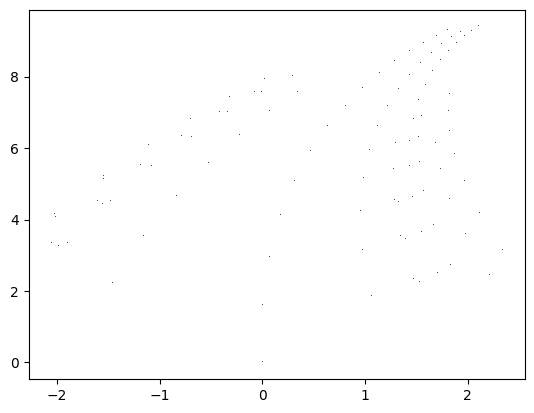

In [37]:
fig, ax = plt.subplots()
ax.scatter(x, y, marker=",", s=(72/fig.dpi)**2, lw=0, color="green")